# nuScenes-mini exploration

Quick notebook to inspect nuScenes-mini annotations and think through a reasonable baseline + GNN extension. Run inside the repo root (or adjust `dataroot`).

## Setup
1. Download nuScenes **mini** from https://www.nuscenes.org/download.
2. Unzip to `data/nuscenes` so you have folders like `samples/`, `sweeps/`, `v1.0-mini/`.
3. Install devkit dependencies (one time):
   ```bash
   pip install nuscenes-devkit matplotlib seaborn tqdm
   ```

In [23]:
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion

# Point to your extracted nuScenes data
dataroot = Path("../data/nuscenes")
version = "v1.0-mini"  # use mini for fast iteration

nusc = NuScenes(version=version, dataroot=str(dataroot), verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.237 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


## Scene / sample overview

In [24]:
print(f"Scenes: {len(nusc.scene)}")
print(f"Samples: {len(nusc.sample)}")
print(f"Annotations: {len(nusc.sample_annotation)}")

# Peek at the first scene and its samples
scene = nusc.scene[0]
print("\nFirst scene:")
print({k: scene[k] for k in ["token", "name", "description", "nbr_samples"]})

# Walk the sample chain for this scene
sample_tokens = []
current_token = scene["first_sample_token"]
while current_token:
    sample_tokens.append(current_token)
    sample = nusc.get("sample", current_token)
    current_token = sample.get("next")

print("Sample tokens in first scene:")
print(sample_tokens)

Scenes: 10
Samples: 404
Annotations: 18538

First scene:
{'token': 'cc8c0bf57f984915a77078b10eb33198', 'name': 'scene-0061', 'description': 'Parked truck, construction, intersection, turn left, following a van', 'nbr_samples': 39}
Sample tokens in first scene:
['ca9a282c9e77460f8360f564131a8af5', '39586f9d59004284a7114a68825e8eec', '356d81f38dd9473ba590f39e266f54e5', 'e0845f5322254dafadbbed75aaa07969', 'c923fe08b2ff4e27975d2bf30934383b', 'f1e3d9d08f044c439ce86a2d6fcca57b', '4f545737bf3347fbbc9af60b0be9a963', '7626dde27d604ac28a0240bdd54eba7a', 'be99ffc878b24aca8956bbb4e0f97d0c', '9813c23a5f1448b09bb7910fea9baf20', '023c4df2d451409881d8e6ea82f14704', 'c235638ed66145988d17f9d0601923f2', 'bc3c8a953f6b4dcdb77b521d89f3d9d5', '1e3d79dae62742a0ad64c91679863358', '2afb9d32310e4546a71cbe432911eca2', 'cd21dbfc3bd749c7b10a5c42562e0c42', '88449a5cb1644a199c1c11f6ac034867', '2ff86dc19c4644a1a88ce5ba848f56e5', 'bf2938e43c6f487497cda76b51bfc406', 'b26e791522294bec90f86fd72226e35c', 'c844bf5a9f2243ff8

## Class distribution

nuScenes defines 23 categories. Mini is tiny; this is just to check coverage.

Top categories:
vehicle.car                    7619
human.pedestrian.adult         4765
movable_object.barrier         2323
movable_object.trafficcone     1378
vehicle.truck                  649
vehicle.motorcycle             471
vehicle.bus.rigid              353
vehicle.bicycle                243
vehicle.construction           196
human.pedestrian.construction_worker 193
movable_object.pushable_pullable 82
vehicle.trailer                60
vehicle.bus.bendy              57
static_object.bicycle_rack     54
human.pedestrian.child         46


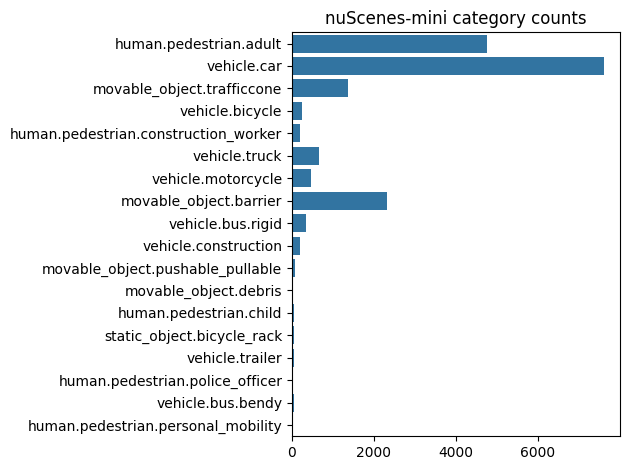

In [25]:
cat_counts = Counter()
attr_counts = Counter()
for ann in nusc.sample_annotation:
    cat = ann["category_name"]  # mini stores category_name directly
    cat_counts[cat] += 1
    for attr_token in ann.get("attribute_tokens", []):
        if attr_token:
            attr_counts[nusc.get("attribute", attr_token)['name']] += 1

print("Top categories:")
for name, count in cat_counts.most_common(15):
    print(f"{name:30s} {count}")

sns.barplot(x=list(cat_counts.values()), y=list(cat_counts.keys()))
plt.title("nuScenes-mini category counts")
plt.tight_layout()
plt.show()

## Sample-level look

Grabs a random sample, lists the lidar/camera sweeps, and shows the 3D boxes as text (for quick inspection without visualization).

In [26]:
import random

sample = nusc.get("sample", random.choice([s['token'] for s in nusc.sample]))
print({k: sample[k] for k in ["token", "scene_token", "timestamp"]})

# Sensor sample_data entries (cams + lidar)
for sd_token in sample["data"].values():
    sd = nusc.get("sample_data", sd_token)
    print(f"{sd['channel']:15s} -> filename={sd['filename']}")

# Show annotation boxes (center xyz, size lwh, yaw)
print("\nBoxes (center, size, yaw):")
for ann_token in sample["anns"][:10]:  # limit output
    ann = nusc.get("sample_annotation", ann_token)
    cat_name = ann["category_name"]  # mini stores category_name directly
    yaw = Quaternion(ann["rotation"]).yaw_pitch_roll[0]
    print(f"{cat_name:25s} center={ann['translation']} size={ann['size']} yaw={yaw:.2f}")

{'token': '4ae9c033164e4e01a0392672686d095c', 'scene_token': '6f83169d067343658251f72e1dd17dbc', 'timestamp': 1535489305447151}
RADAR_FRONT     -> filename=samples/RADAR_FRONT/n008-2018-08-28-16-43-51-0400__RADAR_FRONT__1535489305468000.pcd
RADAR_FRONT_LEFT -> filename=samples/RADAR_FRONT_LEFT/n008-2018-08-28-16-43-51-0400__RADAR_FRONT_LEFT__1535489305421559.pcd
RADAR_FRONT_RIGHT -> filename=samples/RADAR_FRONT_RIGHT/n008-2018-08-28-16-43-51-0400__RADAR_FRONT_RIGHT__1535489305422471.pcd
RADAR_BACK_LEFT -> filename=samples/RADAR_BACK_LEFT/n008-2018-08-28-16-43-51-0400__RADAR_BACK_LEFT__1535489305451237.pcd
RADAR_BACK_RIGHT -> filename=samples/RADAR_BACK_RIGHT/n008-2018-08-28-16-43-51-0400__RADAR_BACK_RIGHT__1535489305479436.pcd
LIDAR_TOP       -> filename=samples/LIDAR_TOP/n008-2018-08-28-16-43-51-0400__LIDAR_TOP__1535489305447151.pcd.bin
CAM_FRONT       -> filename=samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489305412404.jpg
CAM_FRONT_RIGHT -> filename=samples/CAM_F

## Quick visualization

Render a random camera frame with 3D boxes projected. If you're running headless or see matplotlib cache warnings, set `MPLCONFIGDIR=.cache/mpl` before launching the kernel.

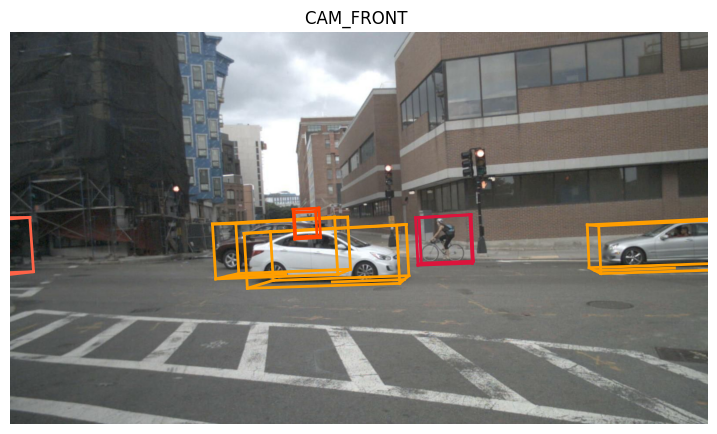

In [27]:

sample_token = random.choice([s['token'] for s in nusc.sample])
cam_token = nusc.get("sample", sample_token)["data"]["CAM_FRONT"]

# This pops a matplotlib figure with boxes; use Agg backend if needed.
nusc.render_sample_data(cam_token, verbose=False)
